In [1]:
# =========================
# 0) Imports & Config
# =========================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, LSTM

DATASET_DIR = '/content/drive/MyDrive/Col/머신러닝 10주차/UCI HAR Dataset'

In [2]:
# =========================
# 1) Data Load Helpers
# =========================
def load_file(p):
    return pd.read_csv(p, header=None, sep=r"\s+", engine="python").values

def load_group(files, pref):
    return np.dstack([load_file(os.path.join(pref, f)) for f in files])

def load_dataset_group(g, root):
    pref = os.path.join(root, g, 'Inertial Signals')
    files = [f'total_acc_{a}_{g}.txt' for a in 'xyz'] + \
            [f'body_acc_{a}_{g}.txt' for a in 'xyz'] + \
            [f'body_gyro_{a}_{g}.txt' for a in 'xyz']
    X = load_group(files, pref)
    y = load_file(os.path.join(root, g, f'y_{g}.txt')).ravel().astype(int)
    return X, y

def load_dataset(root):
    trX, try_ = load_dataset_group('train', root)
    teX, tey  = load_dataset_group('test',  root)
    try_, tey = try_-1, tey-1
    return trX, try_, to_categorical(try_), teX, tey, to_categorical(tey)

In [3]:
# =========================
# 2) Load & Preprocess
# =========================
trainX, trainy, trainy_1h, testX, testy, testy_1h = load_dataset(DATASET_DIR)

# Standardize per channel
scaler = StandardScaler()
trainX = scaler.fit_transform(trainX.reshape(-1, trainX.shape[2])).reshape(trainX.shape).astype('float32')
testX  = scaler.transform(testX.reshape(-1,  testX.shape[2])).reshape(testX.shape).astype('float32')

# Train/Val split
X_train, X_val, y_train_1h, y_val_1h, y_train, y_val = train_test_split(
    trainX, trainy_1h, trainy, test_size=0.2, random_state=100, stratify=trainy
)

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_1h.shape[1]

In [4]:
# =========================
# 3) Build Model (CNN + LSTM)
# =========================
inputs = Input(shape=(n_timesteps, n_features))
x = Conv1D(128, 5, activation='relu', padding='same')(inputs)
x = MaxPooling1D(2)(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2)(x)
x = LSTM(128)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(n_outputs, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 128, 128)       │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,630 (572.77 KB)

 Trainable params: 146,630 (572.77 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# =========================
# 4) Train
# =========================
history = model.fit(
    X_train, y_train_1h,
    epochs=10, batch_size=64,
    validation_data=(X_val, y_val_1h),
    verbose=1
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.6064 - loss: 0.9554 - val_accuracy: 0.8776 - val_loss: 0.3907
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9215 - loss: 0.2288 - val_accuracy: 0.9368 - val_loss: 0.1864
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9413 - loss: 0.1587 - val_accuracy: 0.9497 - val_loss: 0.1349
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9500 - loss: 0.1233 - val_accuracy: 0.9565 - val_loss: 0.1052
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9471 - loss: 0.1132 - val_accuracy: 0.9511 - val_loss: 0.1060
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9512 - loss: 0.1108 - val_accuracy: 0.9585 - val_loss: 0.1173
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9560 - loss: 0.1093 - val_accuracy: 0.9606 - val_loss: 0.1055
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9475 - loss: 0.1166 - val_accuracy: 0.9470 - val_loss

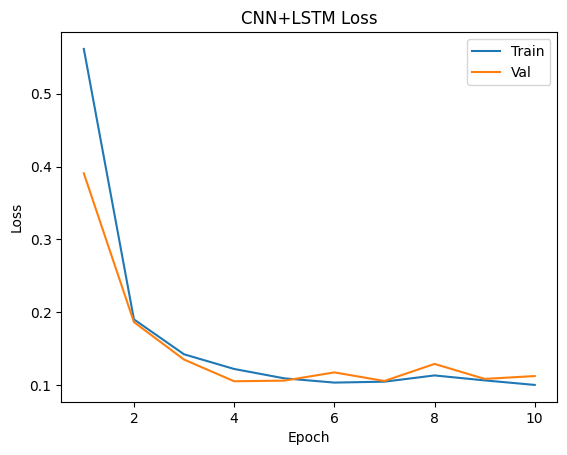

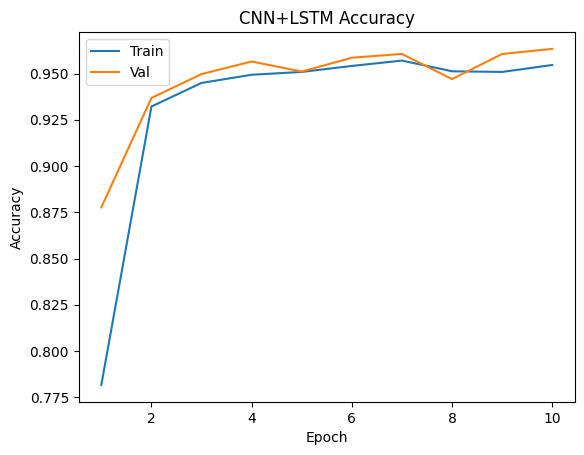

In [6]:
# =========================
# 5) Visualize Training
# =========================
ep = range(1, len(history.history['loss'])+1)
plt.figure(); plt.plot(ep, history.history['loss'], label='Train'); plt.plot(ep, history.history['val_loss'], label='Val');
plt.title('CNN+LSTM Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

plt.figure(); plt.plot(ep, history.history['accuracy'], label='Train'); plt.plot(ep, history.history['val_accuracy'], label='Val');
plt.title('CNN+LSTM Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

CNN+LSTM Test Accuracy: 0.9192399049881235
              precision    recall  f1-score   support

           0     0.9874    0.9496    0.9681       496
           1     0.9349    0.9448    0.9398       471
           2     0.8998    0.9833    0.9397       420
           3     0.8697    0.7882    0.8269       491
           4     0.8298    0.8891    0.8584       532
           5     1.0000    0.9683    0.9839       537

    accuracy                         0.9192      2947
   macro avg     0.9203    0.9206    0.9195      2947
weighted avg     0.9208    0.9192    0.9191      2947



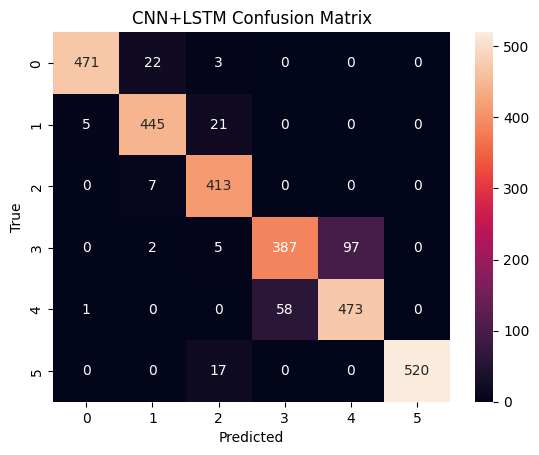

In [7]:
# =========================
# 6) Evaluate on Test
# =========================
probs = model.predict(testX, verbose=0)
pred = np.argmax(probs, axis=-1)
y_true = testy.ravel()

cm = confusion_matrix(y_true, pred)
print('CNN+LSTM Test Accuracy:', accuracy_score(y_true, pred))
print(classification_report(y_true, pred, digits=4))

plt.figure(); sns.heatmap(cm, annot=True, fmt='d');
plt.title('CNN+LSTM Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()